<a href="https://colab.research.google.com/github/LucasBorba1/project_hailmary/blob/main/project_hailmary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Class Definitions

In [20]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# -------------------------------
# Utilities
# -------------------------------
def skew(v):
    x,y,z = v
    return np.array([[0,-z,y],[z,0,-x],[-y,x,0]])

# -------------------------------
# Reaction Wheel
# -------------------------------
class ReactionWheel:
    def __init__(self, axis, max_torque=2e-3, inertia=1e-5, max_speed=8000.0):
        self.axis = np.array(axis, dtype=float) / np.linalg.norm(axis)
        self.max_torque = float(max_torque)   # [N·m]
        self.inertia = float(inertia)         # [kg·m^2]
        self.max_speed = float(max_speed)     # [rad/s] (for completeness)
        self.omega = 0.0                       # wheel spin rate [rad/s]

    def apply_torque(self, torque_cmd, dt):
        # saturate torque
        torque = float(np.clip(torque_cmd, -self.max_torque, self.max_torque))
        # update wheel speed
        self.omega += (torque / self.inertia) * dt
        self.omega = float(np.clip(self.omega, -self.max_speed, self.max_speed))
        # equal and opposite torque on body (along wheel axis)
        return -torque * self.axis, torque  # (body torque, actual wheel torque)

# -------------------------------
# CubeSat
# -------------------------------
class CubeSat:
    def __init__(self, mass=1.6, dimensions=(0.1,0.1,0.2), wheels=None, body_damping=8e-4):
        self.mass = mass
        self.dimensions = dimensions
        # box inertia (principal, CoM)
        self.I = np.diag([
            0.5*mass*(dimensions[1]**2 + dimensions[2]**2),
            0.5*mass*(dimensions[0]**2 + dimensions[2]**2),
            0.5*mass*(dimensions[0]**2 + dimensions[1]**2)
        ])
        self.I_inv = np.linalg.inv(self.I)

        self.omega = np.zeros(3)           # body rates in body frame [rad/s]
        self.attitude = R.identity()       # body->inertial rotation
        self.wheels = wheels if wheels else []

        self.body_damping = float(body_damping)  # viscous rate damping [N·m·s/rad]

        # history for plotting
        self.history = {'omega': [], 'attitude': [], 'tau_body': [], 'tau_cmd_body': []}

    def step(self, wheel_cmds, dt, tau_cmd_body=None):
        # sum torque from all wheels (equal & opposite of what they receive)
        total_torque = np.zeros(3)
        actual_wheel_torques = []

        for wheel, cmd in zip(self.wheels, wheel_cmds):
            tau_body_i, tau_w_i = wheel.apply_torque(cmd, dt)
            total_torque += tau_body_i
            actual_wheel_torques.append(tau_w_i)

        # add simple viscous damping in body
        total_torque -= self.body_damping * self.omega

        # Rigid body dynamics: I*omega_dot = tau - omega x (I*omega)
        omega_dot = self.I_inv @ (total_torque - np.cross(self.omega, self.I @ self.omega))
        self.omega += omega_dot * dt

        # Integrate attitude with incremental rotation
        # (small-angle approx is adequate for small dt)
        self.attitude = self.attitude * R.from_rotvec(self.omega * dt)

        # store history
        self.history['omega'].append(self.omega.copy())
        self.history['attitude'].append(self.attitude.as_quat().copy())
        self.history['tau_body'].append(total_torque.copy())
        if tau_cmd_body is None:
            tau_cmd_body = np.zeros(3)
        self.history['tau_cmd_body'].append(tau_cmd_body.copy())

    def plot_omega(self):
        omega_hist = np.array(self.history['omega'])
        plt.figure(figsize=(7,4))
        plt.plot(omega_hist[:,0], label='wx')
        plt.plot(omega_hist[:,1], label='wy')
        plt.plot(omega_hist[:,2], label='wz')
        plt.legend()
        plt.xlabel('Step')
        plt.ylabel('Angular velocity [rad/s]')
        plt.title('CubeSat Body Angular Velocity')
        plt.grid(True)
        plt.show()

# -------------------------------
# Sensors
# -------------------------------
class Gyro:
    def __init__(self, noise_std=1e-4, bias=np.zeros(3)):
        self.noise_std = noise_std
        self.bias = np.array(bias, dtype=float)
    def read(self, omega_true):
        return omega_true + self.bias + np.random.normal(0, self.noise_std, size=3)

class Accelerometer:
    def __init__(self, noise_std=1e-3):
        self.noise_std = noise_std
    def read(self, accel_true):
        return accel_true + np.random.normal(0, self.noise_std, size=3)

class Magnetometer:
    def __init__(self, noise_std=1e-5, magnetic_field=np.array([1.0,0.0,0.0])):
        self.noise_std = noise_std
        self.magnetic_field = np.array(magnetic_field, dtype=float)
    def read(self, attitude:R):
        mag_body = attitude.inv().apply(self.magnetic_field)
        return mag_body + np.random.normal(0, self.noise_std, size=3)

# -------------------------------
# PID Controller (rate loop -> body torque)
# -------------------------------
class PIDController:
    def __init__(self, Kp, Ki, Kd, tau_limit=6e-3, i_limit=0.05):
        self.Kp = np.array(Kp, dtype=float)
        self.Ki = np.array(Ki, dtype=float)
        self.Kd = np.array(Kd, dtype=float)
        self.tau_limit = float(tau_limit)  # body torque limit (per axis) for anti-windup clamp
        self.i_limit = float(i_limit)      # integral clamp [rad/s·s]
        self.integral = np.zeros(3)
        self.prev_error = np.zeros(3)

    def reset(self):
        self.integral[:] = 0.0
        self.prev_error[:] = 0.0

    def step(self, error, dt):
        # classic PID on body rate error (desired omega = 0)
        self.integral += error * dt
        # anti-windup: clamp integral
        self.integral = np.clip(self.integral, -self.i_limit, self.i_limit)
        derivative = (error - self.prev_error) / dt
        self.prev_error = error

        tau_cmd = self.Kp*error + self.Ki*self.integral + self.Kd*derivative
        # soft clamp of commanded torque (helps anti-windup behavior)
        tau_cmd = np.clip(tau_cmd, -self.tau_limit, self.tau_limit)
        return tau_cmd  # desired body torque [N·m]

# -------------------------------
# Wheel Allocator (3->4 torque mapping)
# -------------------------------
class WheelAllocator:
    """
    Maps desired body torque tau_b (3,) to wheel torques tau_w (4,)
    given wheel axes matrix W = [a1 a2 a3 a4] (3x4).
    Solve: tau_b = W @ tau_w (least squares), then apply per-wheel saturation,
    and re-solve for the residual (two-pass heuristic).
    """
    def __init__(self, wheel_axes, per_wheel_limit):
        self.W = np.stack(wheel_axes, axis=1)  # 3x4
        self.W_pinv = np.linalg.pinv(self.W)   # 4x3
        self.limit = float(per_wheel_limit)

    def allocate(self, tau_b):
        # First pass: unconstrained least-squares
        tau_w = self.W_pinv @ tau_b
        # Saturate per wheel
        tau_w_sat = np.clip(tau_w, -self.limit, self.limit)
        if np.allclose(tau_w, tau_w_sat, atol=1e-12):
            return tau_w_sat

        # Second pass: fix saturated wheels; re-solve for remaining DOFs
        saturated = np.abs(tau_w) > self.limit + 1e-12
        free_idx = np.where(~saturated)[0]
        if len(free_idx) == 0:
            return tau_w_sat

        # residual body torque to be provided by free wheels
        tau_b_residual = tau_b - self.W[:, saturated] @ tau_w_sat[saturated]
        W_free = self.W[:, free_idx]  # 3 x k
        # least squares on free subset
        tau_w_free, *_ = np.linalg.lstsq(W_free, tau_b_residual, rcond=None)
        tau_w2 = tau_w_sat.copy()
        tau_w2[free_idx] = np.clip(tau_w_free, -self.limit, self.limit)
        return tau_w2

# -------------------------------
# Simulator
# -------------------------------
class Simulator:
    def __init__(self, cubesat, controller, allocator, sensors, dt=0.01):
        self.cubesat = cubesat
        self.controller = controller
        self.allocator = allocator
        self.sensors = sensors
        self.dt = dt
        self.time = []

    def run(self, steps, disturbance_torque=None):
        for k in range(steps):
            # Sensors
            gyro = self.sensors['gyro'].read(self.cubesat.omega)
            # Simple rate-hold: desired omega = 0 => error = -gyro
            error = -gyro

            # Controller -> desired body torque
            tau_cmd_body = self.controller.step(error, self.dt)

            # Optional external disturbance torque input (body frame)
            if disturbance_torque is not None:
                tau_cmd_body = tau_cmd_body + disturbance_torque

            # Allocate to 4 wheels
            wheel_cmds = self.allocator.allocate(tau_cmd_body)

            # Step dynamics
            self.cubesat.step(wheel_cmds, self.dt, tau_cmd_body=tau_cmd_body)

            self.time.append(k*self.dt)

# -------------------------------
# Build the 4-wheel pyramidal set
# -------------------------------
def make_pyramid_axes():
    # regular tetrahedron directions (each ~54.7356° from body axes)
    a1 = np.array([ 1,  1,  1])
    a2 = np.array([ 1, -1, -1])
    a3 = np.array([-1,  1, -1])
    a4 = np.array([-1, -1,  1])
    axes = [a/np.linalg.norm(a) for a in (a1,a2,a3,a4)]
    return axes  # list of 4 unit vectors in body frame

# Build dataset

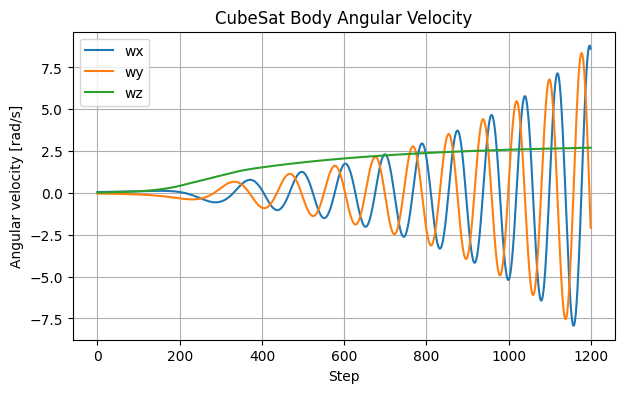

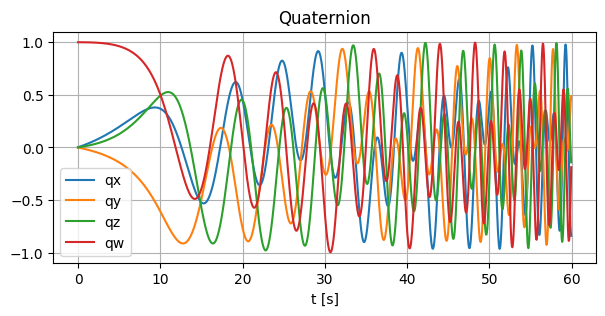

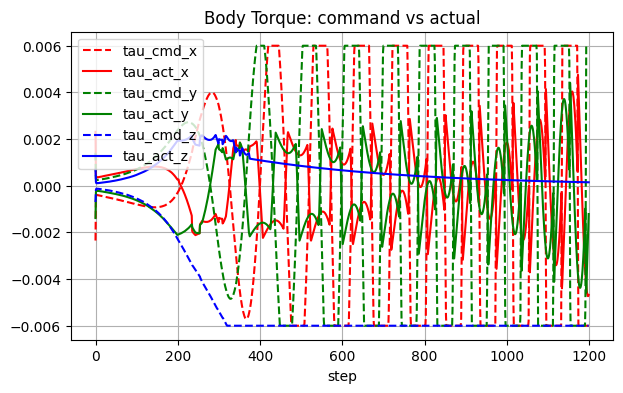

In [21]:
# -------------------------------
# Demo: Disturbance Test Routine
# -------------------------------
np.random.seed(2)  # reproducible

# Create wheels
wheel_axes = make_pyramid_axes()
wheels = [ReactionWheel(axis=ax, max_torque=2e-3, inertia=1e-5, max_speed=12000.0)
          for ax in wheel_axes]

# Create CubeSat
sat = CubeSat(mass=1.6, dimensions=(0.1,0.1,0.2), wheels=wheels, body_damping=8e-4)

# Initial disturbance: body rate (rad/s)
sat.omega = np.array([0.05, -0.03, 0.02])
sat.attitude = R.identity()
sat.history = {'omega': [], 'attitude': [], 'tau_body': [], 'tau_cmd_body': []}

# Controller gains (tuned to settle; start conservative)
# Kp ~ N·m per (rad/s); Kd adds damping; Ki small to remove steady bias
Kp = np.array([7e-3, 7e-3, 5e-3])
Kd = np.array([2e-3, 2e-3, 1.5e-3])
Ki = np.array([2e-4, 2e-4, 1.5e-4])
pid = PIDController(Kp=Kp, Ki=Ki, Kd=Kd, tau_limit=6e-3, i_limit=0.08)

# Sensors
sensors = {
    'gyro':  Gyro(noise_std=2e-5),
    'accel': Accelerometer(noise_std=0.0),
    'mag':   Magnetometer(noise_std=0.0)
}

# Wheel allocator
allocator = WheelAllocator(wheel_axes=wheel_axes, per_wheel_limit=wheels[0].max_torque)

# Simulator
dt = 0.05
sim = Simulator(sat, pid, allocator, sensors, dt=dt)

# Run (no ongoing disturbance torque; only initial rate)
sim.run(steps=1200, disturbance_torque=None)

# Plot results
sat.plot_omega()

# Quick attitude check (optional):
att = np.array(sat.history['attitude'])  # [x,y,z,w]
t = np.arange(len(att))*dt
plt.figure(figsize=(7,3))
plt.plot(t, att[:,0], label='qx')
plt.plot(t, att[:,1], label='qy')
plt.plot(t, att[:,2], label='qz')
plt.plot(t, att[:,3], label='qw')
plt.legend(); plt.grid(True); plt.title('Quaternion'); plt.xlabel('t [s]')
plt.show()

# Plot torque commands vs actual
tau_cmd = np.array(sat.history['tau_cmd_body'])
tau_act = np.array(sat.history['tau_body'])
plt.figure(figsize=(7,4))
plt.plot(tau_cmd[:,0], 'r--', label='tau_cmd_x'); plt.plot(tau_act[:,0], 'r', label='tau_act_x')
plt.plot(tau_cmd[:,1], 'g--', label='tau_cmd_y'); plt.plot(tau_act[:,1], 'g', label='tau_act_y')
plt.plot(tau_cmd[:,2], 'b--', label='tau_cmd_z'); plt.plot(tau_act[:,2], 'b', label='tau_act_z')
plt.legend(); plt.grid(True); plt.title('Body Torque: command vs actual'); plt.xlabel('step')
plt.show()

# Animate


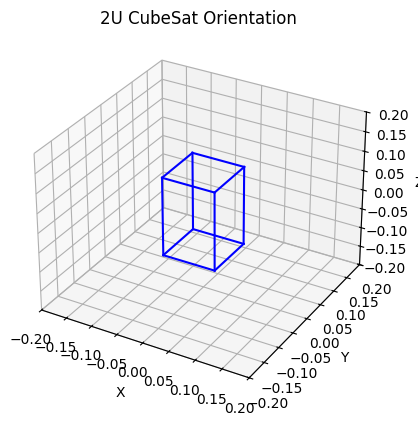

In [22]:
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # MB
from IPython.display import Video


def animate_cubesat(cubesat, interval=100):
    # Cube dimensions (2U)
    Lx, Ly, Lz = cubesat.dimensions
    vertices = np.array([[-Lx/2, -Ly/2, -Lz/2],
                         [ Lx/2, -Ly/2, -Lz/2],
                         [ Lx/2,  Ly/2, -Lz/2],
                         [-Lx/2,  Ly/2, -Lz/2],
                         [-Lx/2, -Ly/2,  Lz/2],
                         [ Lx/2, -Ly/2,  Lz/2],
                         [ Lx/2,  Ly/2,  Lz/2],
                         [-Lx/2,  Ly/2,  Lz/2]])
    edges = [(0,1),(1,2),(2,3),(3,0),
             (4,5),(5,6),(6,7),(7,4),
             (0,4),(1,5),(2,6),(3,7)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-0.2,0.2)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.2,0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('2U CubeSat Orientation')

    lines = [ax.plot([],[],[],color='b')[0] for _ in edges]

    def update(frame):
        quat = cubesat.history['attitude'][frame]
        rot = R.from_quat(quat)
        verts_rot = rot.apply(vertices)
        for i, (start,end) in enumerate(edges):
            lines[i].set_data([verts_rot[start,0], verts_rot[end,0]],
                              [verts_rot[start,1], verts_rot[end,1]])
            lines[i].set_3d_properties([verts_rot[start,2], verts_rot[end,2]])
        return lines

    anim = animation.FuncAnimation(fig, update, frames=len(cubesat.history['attitude']),
                                   interval=interval, blit=False)
    return anim  # return the animation to keep reference

# -------------------------------
# Run the animation in Colab
# -------------------------------
anim = animate_cubesat(sat, interval=100)
#HTML(anim.to_jshtml())
anim.save("cubesat.mp4", writer='ffmpeg', fps=10)
Video("cubesat.mp4")


# Generate dataset


In [19]:
import pandas as pd

# Build dataset
data = []
for i in range(len(sat.history['omega'])):
    omega = sat.history['omega'][i]
    quat = sat.history['attitude'][i]
    # If you want, also include wheel states or sensor readings
    row = {
        'step': i,
        'wx': omega[0],
        'wy': omega[1],
        'wz': omega[2],
        'qx': quat[0],
        'qy': quat[1],
        'qz': quat[2],
        'qw': quat[3],
    }
    data.append(row)

df = pd.DataFrame(data)
df.to_csv('cubesat_sim_data.csv', index=False)
